<a href="https://colab.research.google.com/github/IMOKURI/petfinder-pawpularity-score/blob/main/petfinder_pawpularity_score_zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📔 About this notebook

Image classification baseline.

## 📝 Memo

# Check Environment

In [1]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          85493         862       53781           1       30849       83829
Swap:             0           0           0


In [2]:
!python --version

Python 3.7.12


In [3]:
!nvidia-smi

Fri Sep 24 02:53:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [5]:
# for cuda 11.1
# https://pytorch.org/get-started/locally/
if False:
    !pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

# Prepare for Kaggle

- Add dataset [imokuri/wandbtoken](https://www.kaggle.com/imokuri/wandbtoken)

# Prepare for Colab

In [6]:
import os
import sys
import zipfile

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/content/drive')
        dataset_dir = "/content/drive/MyDrive/Datasets"

        # ====================================================
        # Competition datasets
        # ====================================================
        with zipfile.ZipFile(f"{dataset_dir}/petfinder-pawpularity-score.zip", "r") as zp:
            zp.extractall(path="./")

    # for StratifiedGroupKFold
    # !pip uninstall -y scikit-learn
    # !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    # for MultilabelStratifiedKFold
    # !pip install -q iterative-stratification

    # for CosineAnnealingWarmupRestarts
    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    # !pip install -q optuna

    # ====================================================
    # Competition specific libraries
    # ====================================================
    !pip install -q timm
    !pip install -q albumentations==0.4.6

    !touch init.txt

Already initialized.


# 📚 Library

In [7]:
# General libraries
import collections
import glob
import json
import math
import os
import random
import re
import statistics
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [8]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [9]:
warnings.filterwarnings("ignore")

In [10]:
netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
!cp -f {netrc} ~/
!wandb login

wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    wandb_tags.append(torch.cuda.get_device_name(0))

# Load Data

In [12]:
DATA_DIR = "./" if 'google.colab' in sys.modules else "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [13]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🤔 Config

In [14]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [15]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder-pawpularity-score"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 100

    amp = True

In [16]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 5,
    "epochs": 10,
    "batch_size": 32,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "RMSELoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-4,
    "min_lr": 5e-6,
    "weight_decay": 1e-6,
    "model_name": "tf_efficientnet_b4_ns", # "vit_base_patch16_384",
    "size": 512,
}

In [17]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [18]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [19]:
if Config.debug:
    wandb_tags.append("debug")
    
if Config.amp:
    wandb_tags.append("amp")

In [20]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [21]:
config = wandb.config

# EDA 1

In [22]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


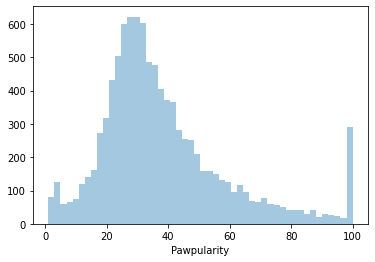

In [23]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

In [24]:
def get_transforms(*, data):
    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# EDA 2

# 👑 Load Artifacts

In [25]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [26]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [27]:
Fold = KFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train)):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold"]).size())

fold
0    1983
1    1983
2    1982
3    1982
4    1982
dtype: int64


# Dataset

In [28]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

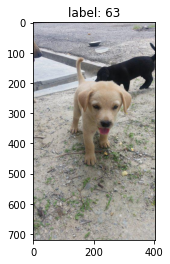

In [29]:
train_ds = BaseDataset(train)
image, label = train_ds[0]
plt.imshow(image)
plt.title(f"label: {label}")
plt.show()

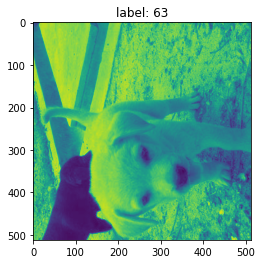

In [30]:
train_ds = BaseDataset(train, transform=get_transforms(data="train"))
image, label = train_ds[0]
plt.imshow(image[0])
plt.title(f"label: {label}")
plt.show()

# 🚗 Model

In [31]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [32]:
if config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, label in train_loader:
        output = model(image)
        print(output)
        break

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_runn

# Optimizer

# Loss

In [33]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [34]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [35]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [37]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1. / norm_type)
    return total_norm

In [38]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with amp.autocast(enabled=Config.amp):
            y_preds = model(images)
            loss = criterion(y_preds.float(), labels.float())
            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps
            
        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [39]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [40]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_folds):
        num_data = len(train_folds)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=num_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=(num_steps // 10)
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_folds)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        # if config.criterion == "BCEWithLogitsLoss":
        #     preds = 1 / (1 + np.exp(-preds))

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s")
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log({
            "epoch": epoch + 1,
            f"loss/train_fold{fold}": avg_loss,
            f"loss/valid_fold{fold}": avg_val_loss,
            f"score/fold{fold}": score,
        })

        if avg_val_loss < best_loss:
            best_score = score
            best_loss = avg_val_loss
            best_preds = preds
            LOGGER.info(f"Epoch {epoch+1} - Save Best Model. score: {best_score:.4f}, loss: {best_loss:.4f}")

            torch.save(
                {"model": model.state_dict(), "preds": preds}, MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            # use artifacts instead
            # wandb.save(MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    # valid_folds[[str(c) for c in range(config.n_class)]] = best_preds
    # valid_folds["preds"] = best_preds.argmax(1)
    valid_folds["preds"] = best_preds

    return valid_folds, best_score, best_loss

# Main function

In [41]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])
            
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns = ["fold", "score", "loss"])
        run.log({"Fold Result": table})
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type='model')
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)


# 🚀 Run

In [ ]:
main()

========== fold: 0 training ==========


Epoch: [1][0/247] Elapsed 0m 2s (remain 8m 50s) Loss: 34.0016 Grad: 2.9450 LR: 0.000100  
Epoch: [1][100/247] Elapsed 0m 43s (remain 1m 2s) Loss: 38.7908 Grad: nan LR: 0.000100  


In [ ]:
wandb.finish()

In [ ]:
!nvidia-smi